# KS Equation

Solution to the Kuramoto-Sivashinsky equation based on R. L. Davidchak's implementationo f Kassam and Trefethen code: [Link](ChaosBook.org/extras/#PDEs).

\begin{equation}
    u_t = -uu_x - u_{xx} - u_{xxxx}
\end{equation}

Let $L = 2\pi\tilde{L}$ be the system parameter relating to the grid length spatially. Let $u(x,t)$ represent a scalar field such that $u(x,t) = u(x+2\pi,t)$. We begin by expanding $u(x,t)$ in it's Fourier basis:

\begin{equation}
    u(x,t) = \sum_{k = -\infty}^{k = \infty} a_{k}(t)e^{ikx/\tilde{L}}
\end{equation}

We do this so that the entire calculation is in Fourier space, giving us scalar instead of matrix computation (for more information on this, see [here](https://people.maths.ox.ac.uk/trefethen/publication/PDF/2005_111.pdf).

We then implement the Fourth-Order Runge Kutta method. The complete set of update equations are given by:

\begin{equation}
a_{n}=u_{n} e^{c h / 2}+\left(e^{c h / 2}-1\right) F\left(u_{n}, t_{n}\right) / c
\end{equation}

\begin{equation}
b_{n}=u_{n} e^{c h / 2}+\left(e^{c h / 2}-1\right) F\left(a_{n}, t_{n}+h / 2\right) / c
\end{equation}

\begin{equation}
c_{n}=a_{n} e^{c h / 2}+\left(e^{c h / 2}-1\right)\left(2 F\left(b_{n}, t_{n}+h / 2\right)-F\left(u_{n}, t_{n}\right)\right) / c
\end{equation}

\begin{aligned} u_{n+1}=& u_{n} e^{c h}+\left\{F\left(u_{n}, t_{n}\right)\left[-4-h c+e^{c h}\left(4-3 h c+h^{2} c^{2}\right)\right]\right.\\ &+2\left(F\left(a_{n}, t_{n}+h / 2\right)+F\left(b_{n}, t_{n}+h / 2\right)\right)\left[2+h c+e^{c h}(-2+h c)\right] \\ &\left.+F\left(c_{n}, t_{n}+h\right)\left[-4-3 h c-h^{2} c^{2}+e^{c h}(4-h c)\right]\right\} / h^{2} c^{3} \end{aligned}

where $F$ is our transformation to and from Fourier space. I also note that $c$ is a constant (exponential time integration factor) and $h$ is the system parameter $\tilde{L}$. 

---------------------------------------------------------------------------------------------------

We then define two functions. The first one solves for the Fourier modes as function of time ($\texttt{ksfmstp}$). Then, we define a function that takes the Fourier modes and outputs to $u(x,t)$ space. I have included an example use of the two functions, a plot of the Fourier modes, a plot of the real output $u(x,t)$, a plot of the last 500 timesteps (used for prediction), a plot to show the boundary conditions are satisfied, and two chunks of code to make animations of the solution.

# Library Import

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.fft import fft, ifft

# KS Solver Functions

### KS Equation Fourier Modes

In [2]:
def ksfmstp(a0, d, h, nstp, npt = 1):
    N = len(a0)+2
    Nh = int(N/2);
    v = np.hstack((np.array((0)),
               np.array((a0[0:len(a0)-1:2]+1j*a0[1:len(a0):2])),
               np.array([0]),
               np.array(a0[0:len(a0)-1:2][::-1]-1j*a0[1:len(a0):2][::-1])))
    v = v.reshape(-1,1)

    k = (2*np.pi/d)*(np.hstack((np.arange(0, N/2, 1), 0, np.arange(-N/2 + 1,0,1))).reshape(-1,1));   # wave numbers
    L = k**2 - k**4;                        # Fourier multipliers
    E = np.exp(h*L);  
    E2 = np.exp(h*L/2);
    M = 16;                                 # no. of points for complex means
    r = np.exp(1j*np.pi*(np.arange(0.5, 16.5, 1))/M);            # roots of unity


    LR = h*np.tile(L,(1,M)) + np.tile(r,(N,1));
    Q  = h*np.real(np.mean((np.exp(LR/2)-1)/LR,1));
    f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3 ,1));
    f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3 ,1));
    f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3 ,1));
    tt = 0;  
    g = 0.5j*k*N;
    
    #pre-allocate arrays
    tt = np.arange(0, nstp*h + h,h)
    aa = np.zeros((N-2,nstp+1))
    aa[:,0] = a0
    
    for q in range(1,nstp+1):
        Nv = g*fft(np.real(ifft(v, axis = 0))**2, axis = 0)
        a = E2*v + Q*Nv
        a = a[:,0].reshape(N,1)
        Na = g*fft(np.real(ifft(a, axis = 0))**2, axis = 0)
        b = E2*v + Q*Na
        b = b[:,0].reshape(N,1)
        Nb = g*fft(np.real(ifft(b, axis = 0))**2, axis = 0)
        c = E2*a + Q*(2*Nb-Nv)
        c = c[:,0].reshape(N,1)
        Nc = g*fft(np.real(ifft(c, axis = 0))**2, axis = 0)
        v = E.reshape((N,1))*v.reshape((N,1)) + Nv.reshape((N,1))*f1.reshape((N,1)) + 2*(Na.reshape((N,1))+Nb.reshape((N,1)))*f2.reshape((N,1)) + Nc.reshape((N,1))*f3.reshape((N,1))
        
        if ((npt > 0) and (q%npt == 0) and (q < nstp)):
            y1 = np.transpose(np.hstack((np.real(v[1:Nh]),np.imag(v[1:Nh]))))
            aa[:,q] = y1.reshape((N-2), order = 'F')
            
    if (npt > 0):
        y1 = np.transpose(np.hstack((np.real(v[1:Nh]),np.imag(v[1:Nh]))))
    if (npt > 0):
        aa[:,q] = y1.reshape((N-2), order = 'F')
        
    return tt, aa

### KS Fourier Mode to Real Space U(x,t)

In [3]:
def ksfm2real(a, L):
    n = np.size(a,0) + 2
    
    nt = np.size(a,1)
    x = L*np.transpose(np.arange(-n/2,n/2+1))/n
    
    v = a[0:-1:2, :] + 1j*a[1:len(a):2,:]
    vv = np.vstack((np.zeros((1,nt)),v,np.zeros((n-np.size(aa,0)-1,nt)),np.flipud(np.conj(v))))
    u = np.real(fft(vv, axis = 0))
    u = np.vstack((u,u[1,:]))
    
    return x, u

# Call Functions

In [4]:
%%time
    # spatial grid points
N = 64
    # spatial dimension
d = 22
    # timestep
h = 0.25
    # number of time steps
nstp = 100000
    # honestly not sure but same as matlab simulation
npt = 0.25

##########################
# Random Initial Condition
##########################
a0 = 0.1*np.random.rand(N-2)

##########################
# Periodic Initial Condition
##########################
# inter = np.linspace(0,2*np.pi, N-2)
# a0 = 0.1*np.cos(inter)

# call functions
tt, aa = ksfmstp(a0, d, h, nstp, npt = 0.25)
x, ut = ksfm2real(aa, d)

CPU times: user 22.3 s, sys: 65.4 ms, total: 22.4 s
Wall time: 22.4 s


### Plot Fourier Modes

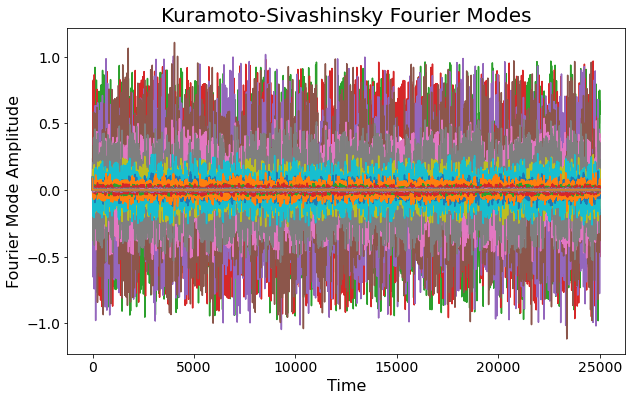

In [5]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(tt,np.transpose(aa))
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Fourier Mode Amplitude', fontsize = 16)
plt.title('Kuramoto-Sivashinsky Fourier Modes', fontsize = 20)
ax.tick_params(axis='both', labelsize=14)
plt.savefig('fourier_modes.png', dpi = 200)
plt.show()

### Plot Full Solution in $(x,t)$ Space

<ipython-input-21-633788480665>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(tt,x,ut, cmap = 'hsv')


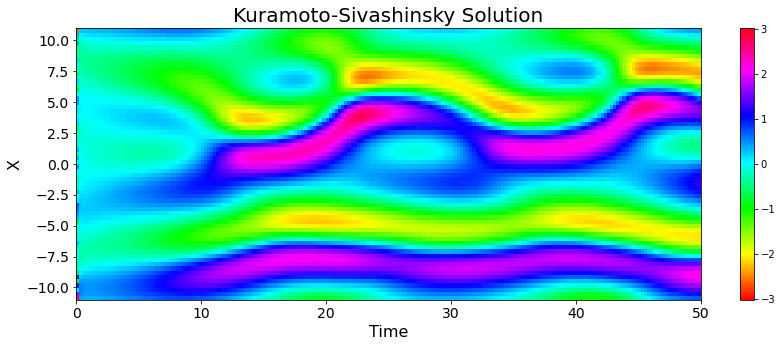

In [21]:
fig, ax = plt.subplots(figsize = (14,5))
plt.xlabel('Time', fontsize = 16)
plt.ylabel('X', fontsize = 16)
plt.title('Kuramoto-Sivashinsky Solution', fontsize = 20)
plt.pcolor(tt,x,ut, cmap = 'hsv')
plt.xlim(0,50)
plt.colorbar()
ax.tick_params(axis='both', labelsize=14)
#plt.savefig('ks_python_solution.png', dpi = 200)
plt.show()

### Last 500 Time Steps

<ipython-input-13-e3f26a314a4d>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(tt[:][-501:-1],x,ut[:,-501:-1], cmap = 'hsv')


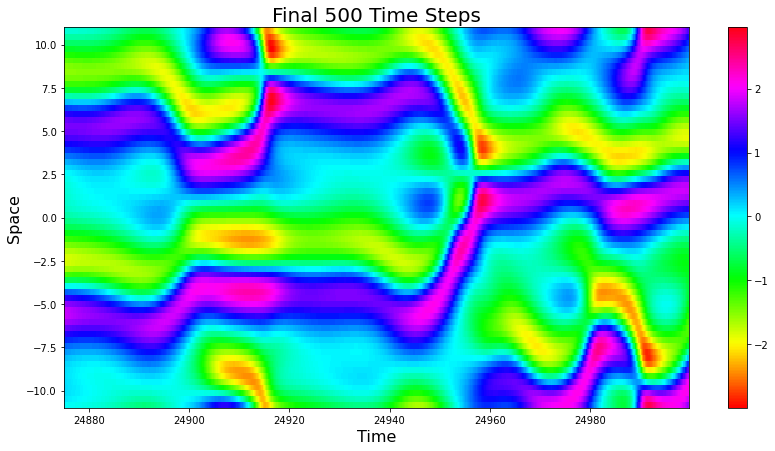

In [13]:
plt.figure(figsize = (14,7))
plt.pcolor(tt[:][-501:-1],x,ut[:,-501:-1], cmap = 'hsv')
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Space', fontsize = 16)
plt.title('Final 500 Time Steps', fontsize = 20)
plt.colorbar()
#plt.savefig('final500.png', dpi = 150)
plt.show()

### Check Boundary Conditions

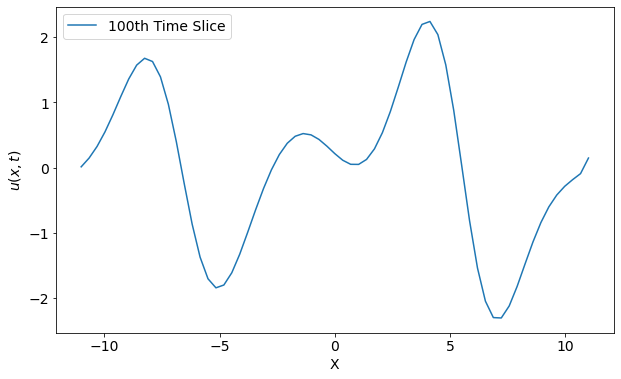

In [14]:
slice1 = 100

fig, ax = plt.subplots(figsize = (10,6))
plt.plot(x,ut[:,slice1], label = f'{slice1}th Time Slice')
plt.xlabel('X', fontsize = 14)
plt.ylabel('$u(x,t)$', fontsize = 14)
plt.legend(fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
plt.savefig('boundary.png', dpi = 200)
plt.show()

### Single Panel Animation

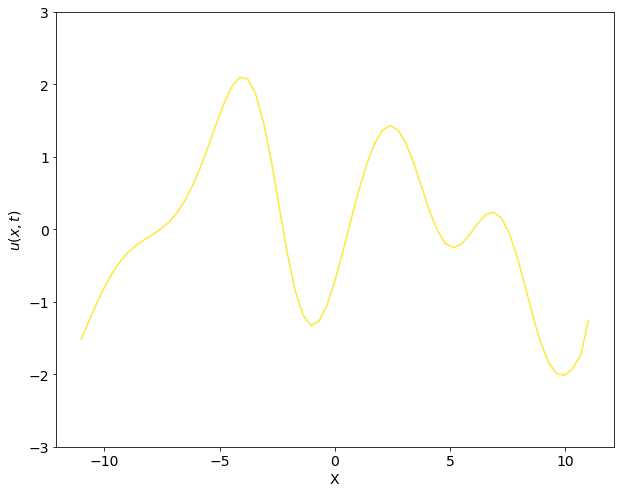

In [15]:
from matplotlib.pylab import *
import matplotlib.animation as animation

#get colormap
palette = plt.get_cmap('cividis')

#initialize figures
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 8))

def updateData(curr):
    # plot
    ax.clear()
    ax.set_ylim([-3, 3])
    ax.set_xlabel('X', fontsize = 14)
    ax.set_ylabel('$u(x,t)$', fontsize = 14)
    ax.tick_params(axis='both', labelsize=14)
    ax.plot(x, ut[:,curr], color = palette(curr/1001))
    
simulation = animation.FuncAnimation(fig, updateData, frames = 1001, interval=20, repeat=False)

simulation.save('ks_sol.gif', writer = 'pillow')


### Two Panel Animation

In [ ]:
from matplotlib.pylab import *
import matplotlib.animation as animation

#get colormap
palette = plt.get_cmap('cividis')

#initialize figures
fig, ((ax1), (ax2)) = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
ax1.set_xlabel('Time', fontsize = 14)
ax1.set_ylabel('Space', fontsize = 14)
ax1.tick_params(axis='both', labelsize=14)
ax1.pcolor(tt,x,ut, cmap = 'viridis')
ax2.set_xlabel('X', fontsize = 14)
ax2.set_ylabel('$u(x,t)$', fontsize = 14)
ax2.tick_params(axis='both', labelsize=14)

def updateData(curr):
    print(curr)
    #top plot
    ax1.axvline(x = tt[curr], color = 'white', lw = 3, alpha = 0.1)
    
    # bottom plot
    ax2.clear()
    ax2.set_xlabel('Space', fontsize = 14)
    ax2.set_ylabel('$u(x,t)$', fontsize = 14)
    ax2.tick_params(axis='both', labelsize=14)
    ax2.plot(x, ut[:,curr], color = palette(curr/1001))
    
simulation = animation.FuncAnimation(fig, updateData, frames=1001, interval=20, repeat=False)

simulation.save('ks_sol_two_panel.gif', writer = 'pillow')